In [1]:
import geopandas as gpd
import contextily as cx
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.crs import CRS
import rioxarray as rxr
import numpy as np

In [27]:
import pandas as pd

#### Research Question

#### Data

In [3]:
nb_path = pathlib.Path().resolve()

In [6]:
nb_path

WindowsPath('C:/Users/roseh/Desktop/785/forest_comp')

#### Study Area

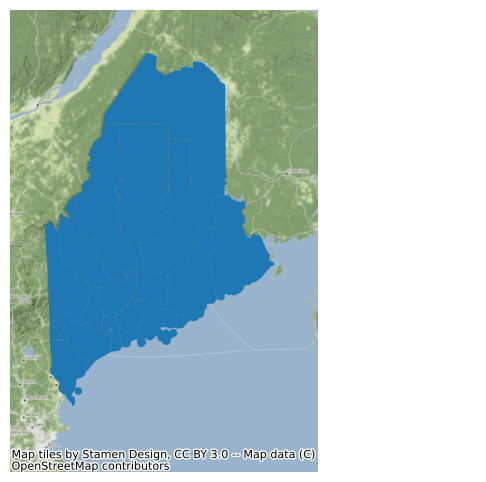

In [30]:
filepath = nb_path / 'data' / 'maine' / 'Maine_County_Boundary_Polygons_Dissolved_Feature.shp'

maine = gpd.read_file(filepath)  # read in Maine shapefile


maine_3857 = maine.to_crs("EPSG:3857")  # reproject to Web Mercator

maine_map = cx.Place('Maine')          # define Maine basemap


fig,ax = plt.subplots(figsize=(4,6))    # plot shapefile on basemap
maine_map.plot(ax=ax)
maine_3857.plot(ax=ax)
ax.axis('off')
plt.show()

#### How have mean annual temperatures changed over time in the study area?

In [32]:
filepath = nb_path / 'data' / 'temps'    # set filepath

In [14]:
 # read in and open raster files with no data values masked and reduced to 2-d
all_files = [rxr.open_rasterio(i, masked=True).squeeze() for i in glob.glob(os.path.join(filepath,'*tmean.tif'))]

In [15]:
web_mercator = CRS.from_string('EPSG:3857')   # create crs object

all_files_3857 = [file.rio.reproject(web_mercator) for file in all_files]    # Reproject all files using the crs object

In [16]:
temps_1980, temps_1990, temps_2000, temps_2010, temps_2020 = all_files_3857  # unpack reprojected files

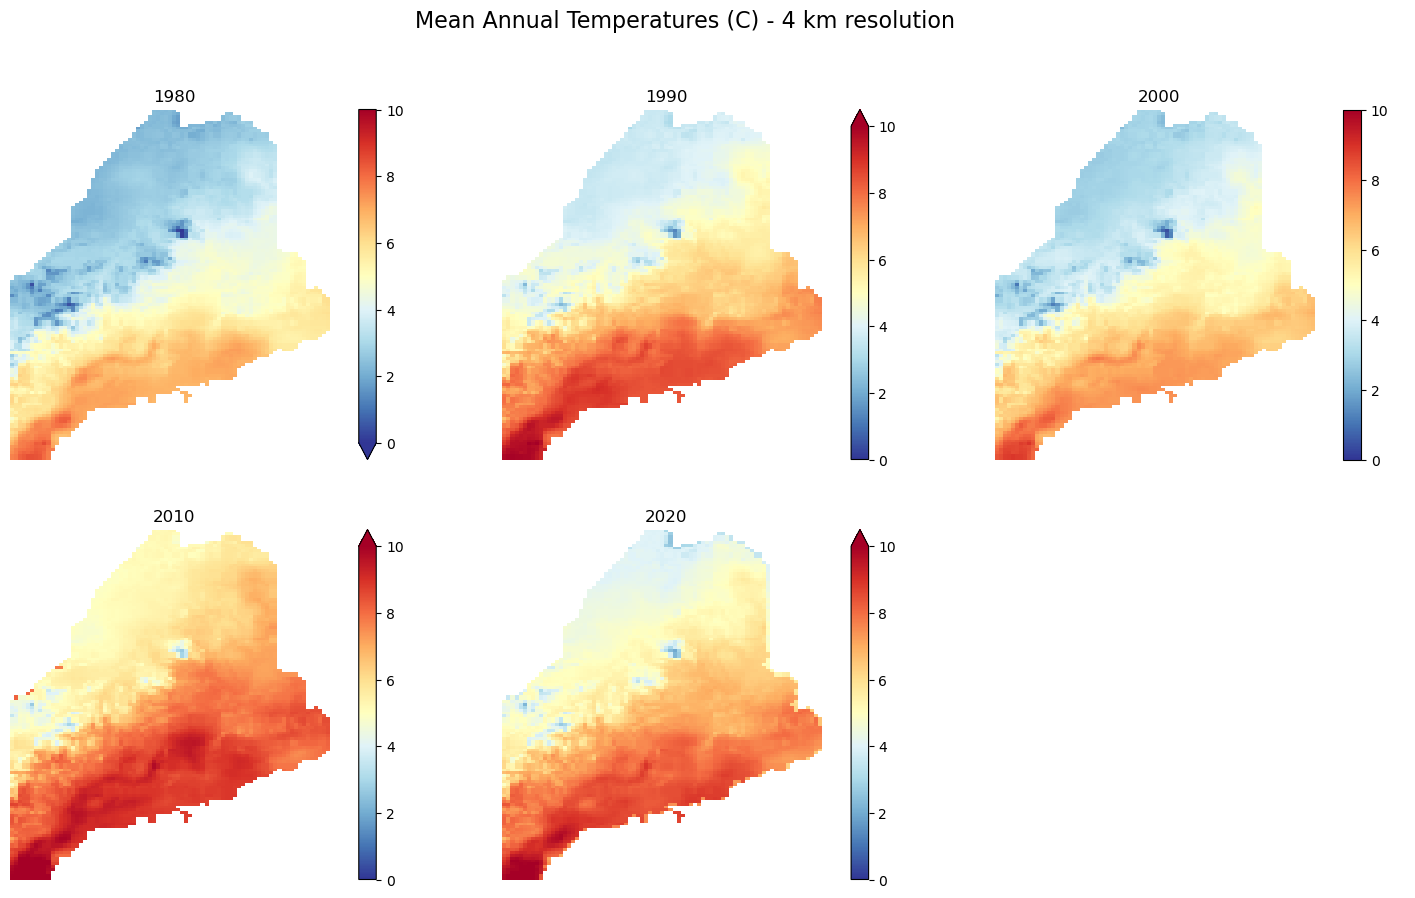

In [26]:
fig, ax = plt.subplots(2,3,figsize=(18,10))
fig.suptitle('Mean Annual Temperatures (C) - 4 km resolution', fontsize=16)

temps_1980.plot(ax=ax[0][0], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[0][0].set_title('1980')
ax[0][0].axis('off')

temps_1990.plot(ax=ax[0][1], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[0][1].set_title('1990')
ax[0][1].axis('off')

temps_2000.plot(ax=ax[0][2], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[0][2].set_title('2000')
ax[0][2].axis('off')

temps_2010.plot(ax=ax[1][0], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[1][0].set_title('2010')
ax[1][0].axis('off')

temps_2020.plot(ax=ax[1][1], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[1][1].set_title('2020')
ax[1][1].axis('off')

ax[1][2].axis('off')

plt.show()

In [38]:
county_temps = pd.read_csv(os.path.join(filepath, 'all_county_temps_formatted.csv'))

county_temps_grouped = county_temps.groupby('County')   # group dataframe by county
counties = [i for i in county_temps['County'].unique()]   # create list of county names

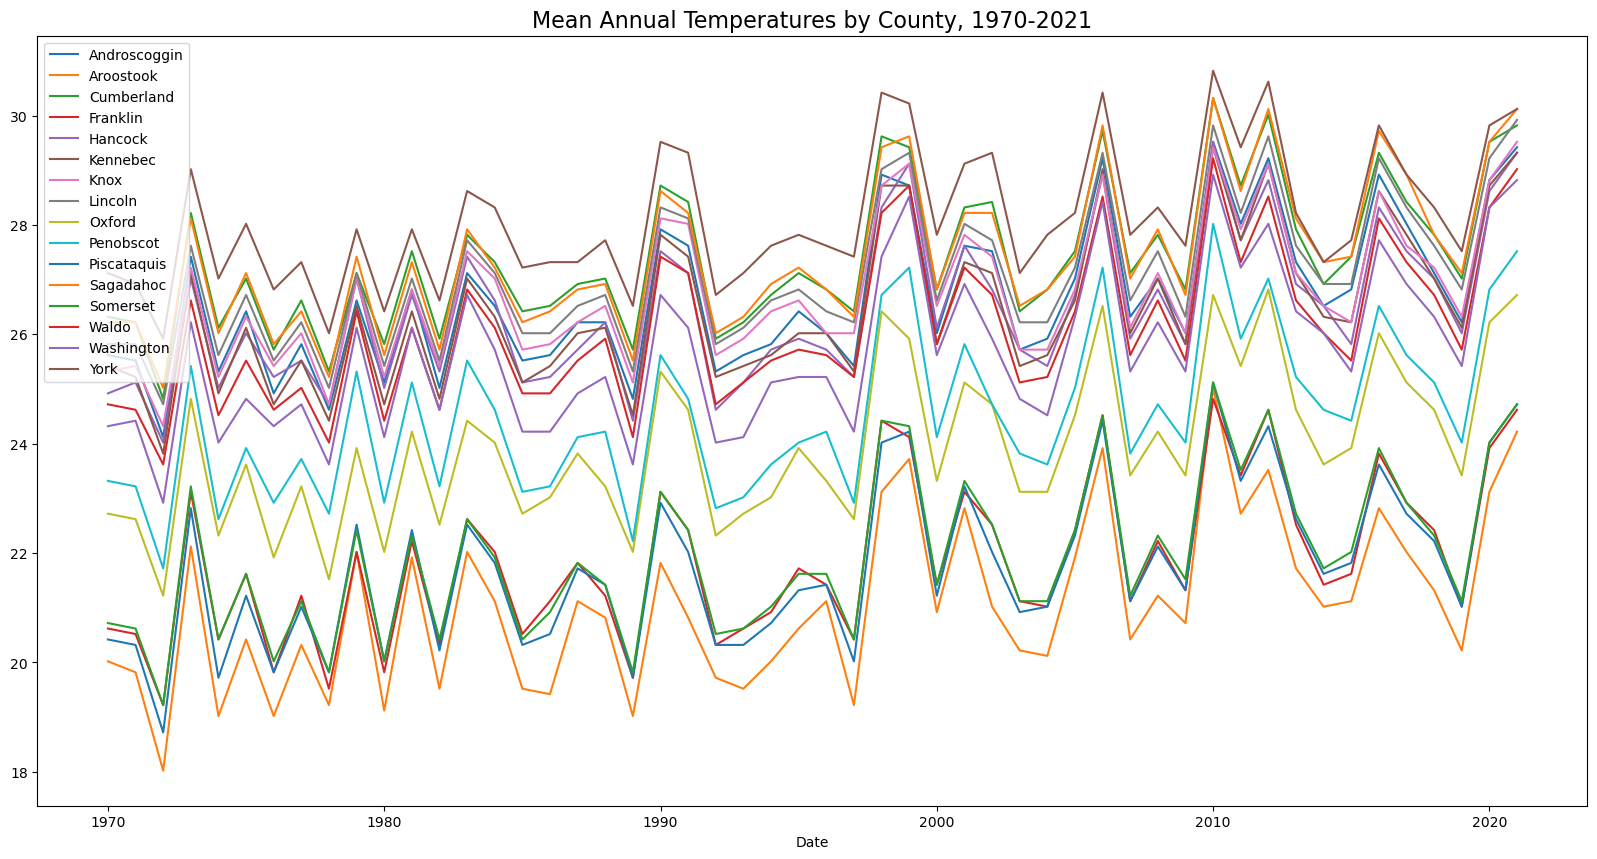

In [50]:
fig, ax = plt.subplots(figsize=(20,10))

for county in counties:                                                   # loop through county groups and plot temps on same axis
    county_temps_grouped.get_group(county).plot(x='Date',y='Value',ax=ax)
ax.legend(counties, loc='upper left')

plt.title('Mean Annual Temperatures by County, 1970-2021', fontsize=16)
plt.show()

#### What is the Relationship Between Forest Species Composition and Temperature?

In [51]:
forest_2021_temps = pd.read_csv(os.path.join(filepath,'2021_forest_cover_w_50yr_mean_temps.csv'))

In [52]:
forest_2021_temps.head()

,COUNTY,County code and name,Total,Red pine,Eastern white pine,Balsam fir,White spruce,Black spruce,Tamarack,Northern white-cedar,Oak,Northern hardwoods,Lowland hardwoods,Aspen,Birch,Balsam poplar,Non stocked,Other,50_yr_mean_temp
0,Androscoggin,23001 ME Androscoggin,195667.0,0.000000,15.939837,0.000000,0.000000,0.000000,0.000000,0.000000,6.134913,45.501285,12.065397,0.638329,0.000000,0.000000,1.488243,18.231996,26.683462
1,Aroostook,23003 ME Aroostook,3855540.0,0.320085,0.319385,18.716548,2.568408,4.722711,1.067529,8.940045,0.000000,37.546803,0.697827,6.763229,3.390809,1.512992,0.201710,13.231973,21.066154
2,Cumberland,23005 ME Cumberland,355284.0,0.000000,37.145776,0.000000,0.000000,0.000000,0.000000,0.000000,17.440414,31.177312,4.884262,1.128675,0.000000,0.000000,0.000000,8.223281,27.402692
3,Franklin,23007 ME Franklin,1012749.0,0.147618,2.256630,10.544172,0.669169,0.669169,0.000000,3.249078,0.000000,54.583120,0.475834,8.293763,9.314055,0.000000,0.184942,9.612550,21.864231
4,Hancock,23009 ME Hancock,896019.0,0.000000,8.650040,9.528704,0.792506,7.348951,0.239727,4.326248,2.920362,33.001086,2.601954,3.636642,2.005203,0.000000,0.000000,24.948690,26.439231


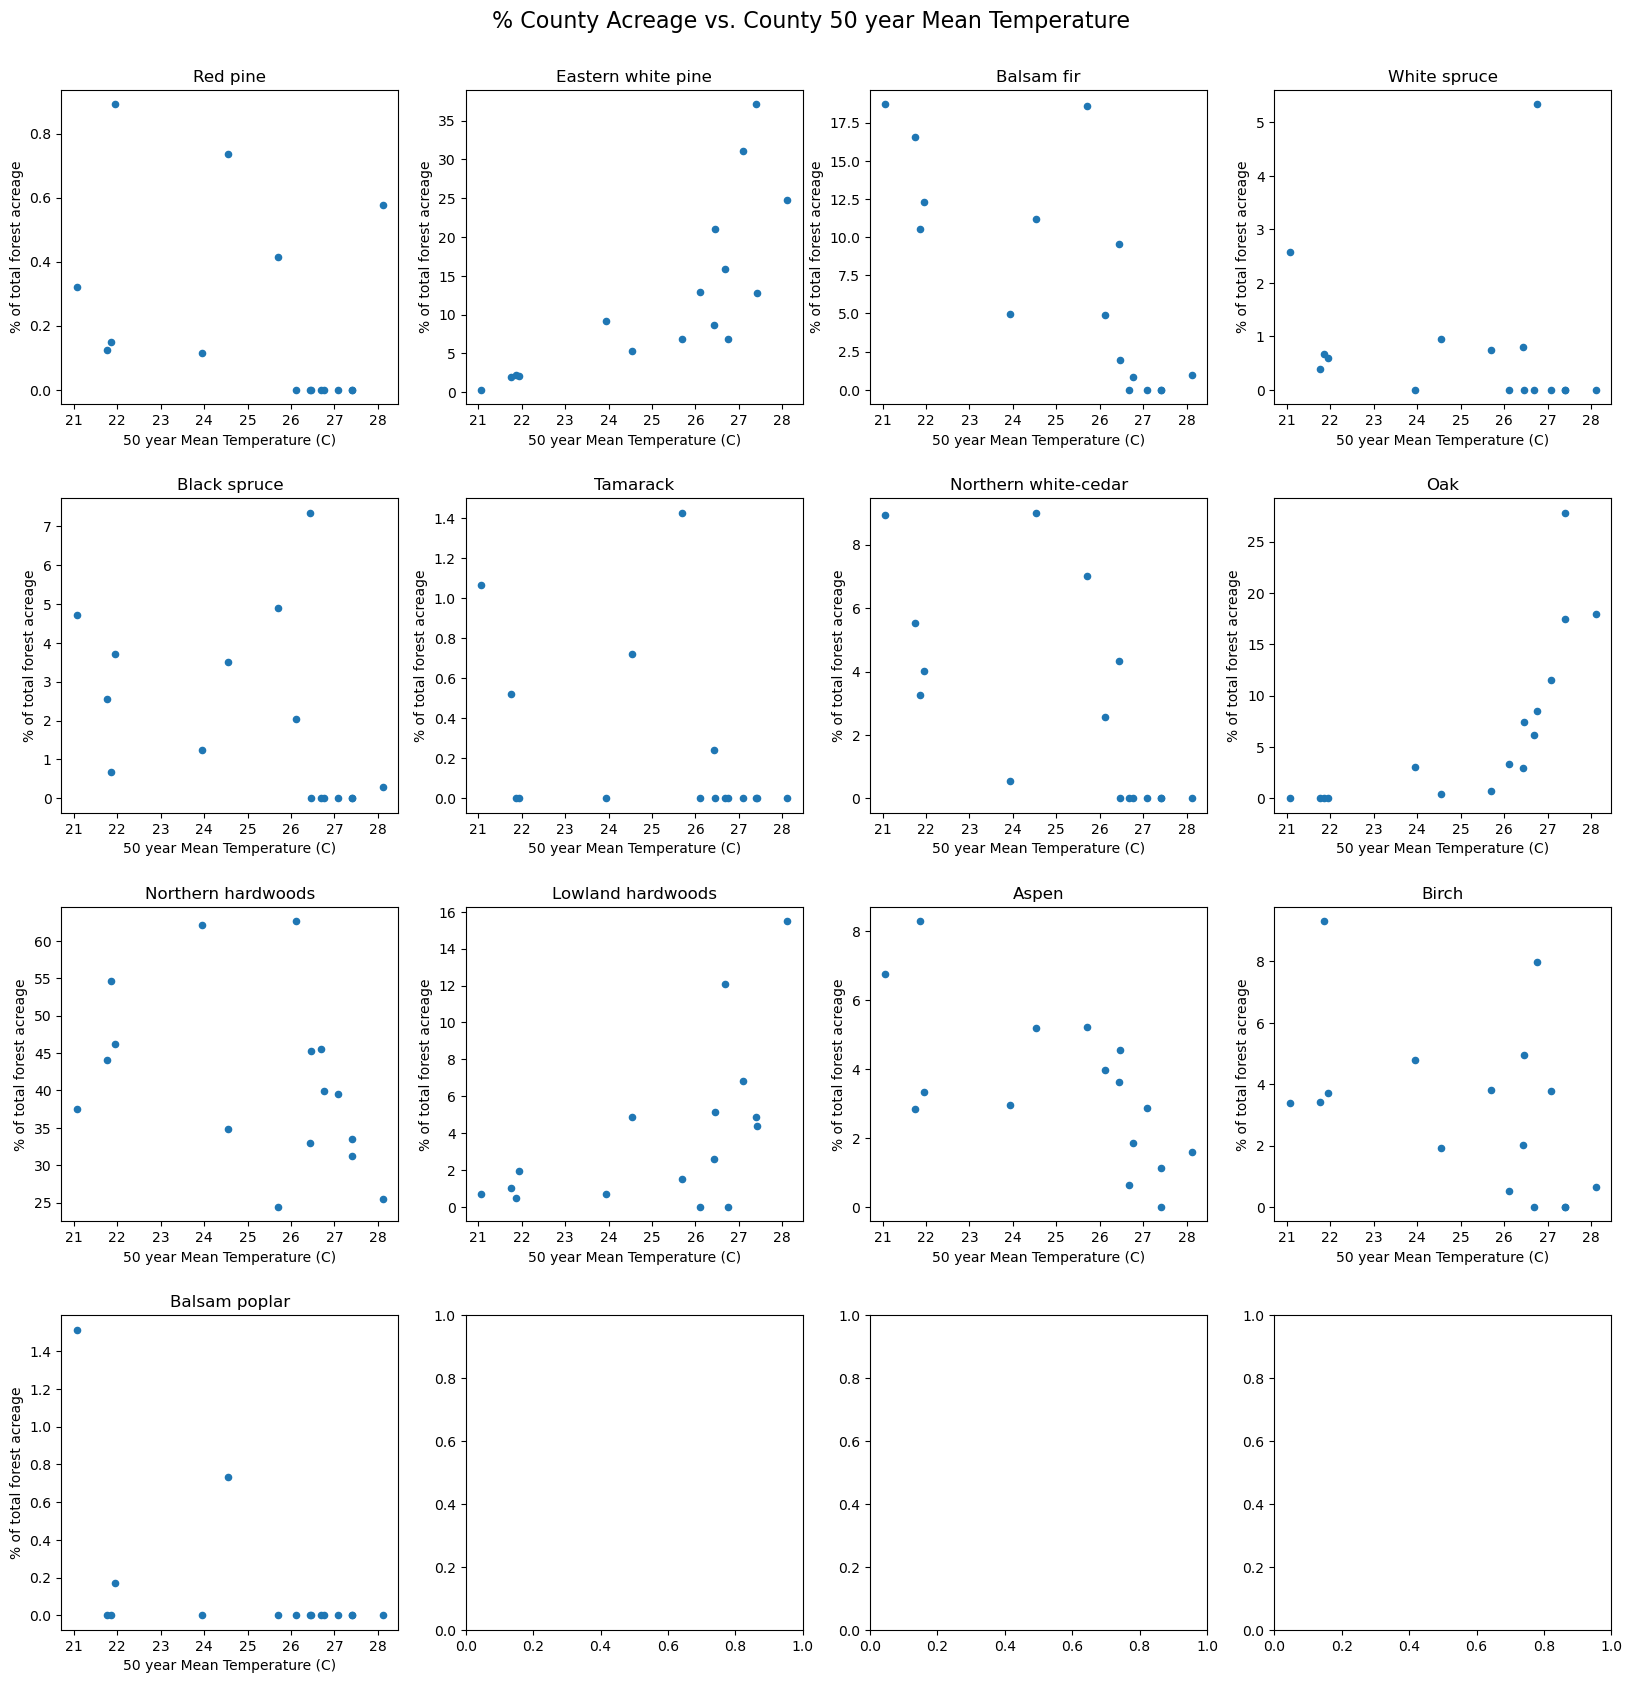

In [71]:
fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(20,20))
fig.suptitle('% County Acreage vs. County 50-year Mean Temperature', fontsize=16, y=.92)
plt.subplots_adjust(hspace=0.3)

species = forest_2021_temps.columns[3:16]

for species, ax in zip(species,axs.ravel()):
    forest_2021_temps.plot(x='50_yr_mean_temp',y=species,kind='scatter',ax=ax)
    ax.set_ylabel('% of total forest acreage')
    ax.set_xlabel('50 year Mean Temperature (C)')
    ax.set_title(species)